Libraries

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import json
import string
import requests
import copy
import random

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from collections import defaultdict
from itertools import combinations
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import display

In [ ]:
url = "https://www.ux.uis.no/~vsetty/data/assignment2_aricles.json"
response = requests.get(url)
articles = response.json()

df = pd.DataFrame(articles)
display(df.head())

,article_id,Title,Content
0,0,Tikcro enters into research and license agreem...,Tikcro enters into research and license agreem...
1,1,Facebook Friend Request Nearly Cost One North ...,A North Carolina woman is trying to warn other...
2,2,Amlin plc UK Regulatory Announcement: Total Vo...,LONDON--(BUSINESS WIRE)--\n\nAMLIN plc\n\nTOTA...
3,3,Khaleda asks for security,Khaleda asks for security\n\n\n\nBNP Chairpers...
4,4,Liberian Health Clinics Reopen Slowly with Ren...,Liberian Health Clinics Reopen Slowly with Ren...


In [ ]:
print(f"Total articles: {len(articles)}")
print("Key of articles",articles[0].keys())

Total articles: 48505
Key of articles dict_keys(['article_id', 'Title', 'Content'])


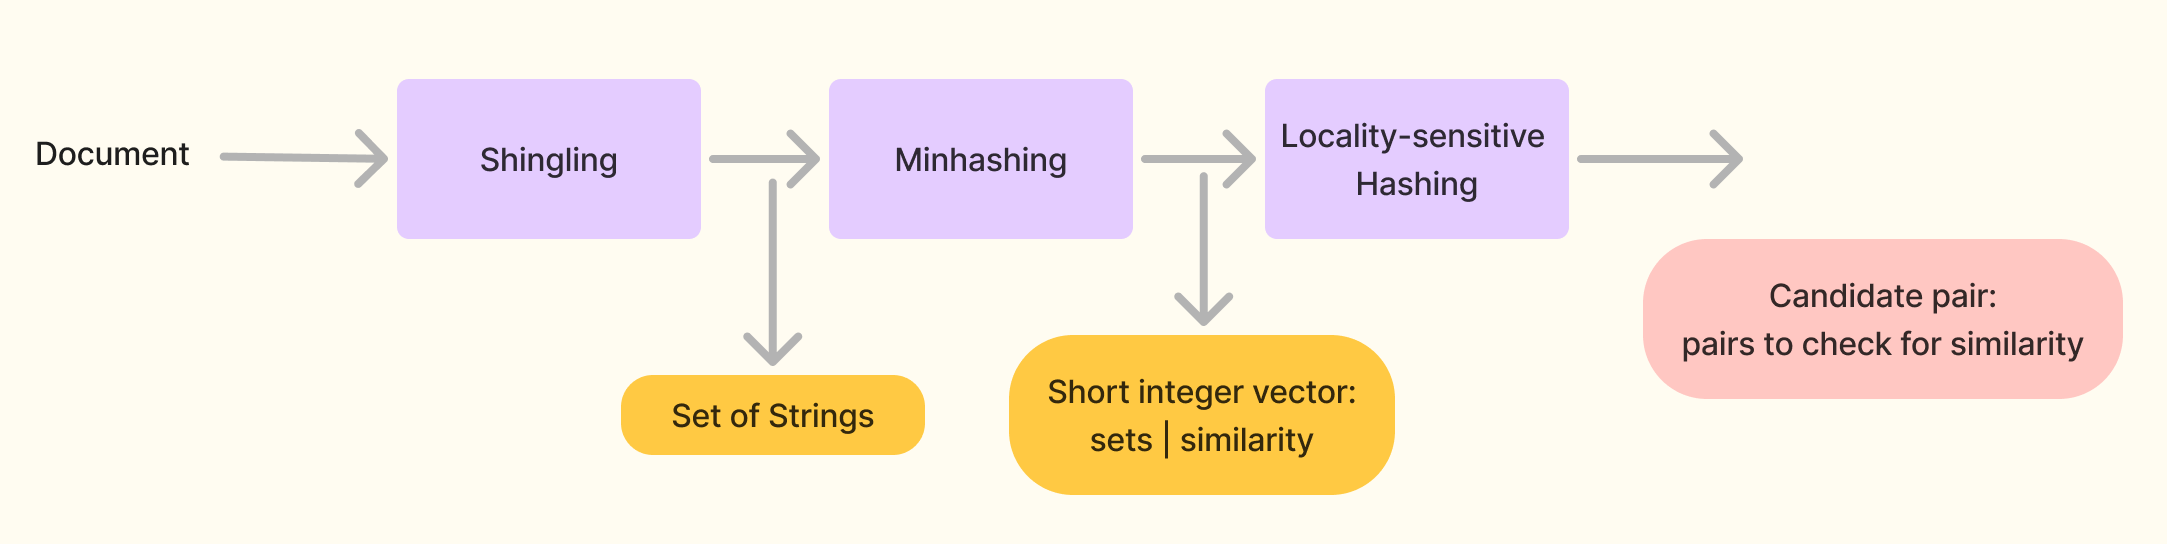

**Preprocessing**
- Remove special characters and punctuation
- Convert text to lowercase
- Tokenize the text into words
- Remove stopwords (common words like "the", "is", "and") and digits

In [ ]:
def preprocess_article(text, n=2):
    stop_words = set(stopwords.words('english'))

    translator = str.maketrans('', '', string.punctuation)
    cleaned_text = text.translate(translator).lower()
    tokens = [word for word in cleaned_text.split() if word not in stop_words and word.isalpha()]

    n_grams = list(ngrams(tokens, n))

    return n_grams

- Extracts text from each article (title + content)
- Preprocesses the text
- Generates n-grams from the cleaned text
- Counts the n-gram occurrences across all documents
- Returns the top top_n most frequent n-grams as a set

In [ ]:
def getFrequentNgrams(articles, n=2, top_k=10000):
    ngram_counter = Counter()

    for article in articles:
        title = article.get('Title', '')
        content = article.get('Content', '')

        ngrams_in_article = preprocess_article(f"{title} {content}", n)
        ngram_counter.update(ngrams_in_article)

    most_frequent_ngrams = ngram_counter.most_common(top_k)
    frequent_ngrams = [ngram for ngram, _ in most_frequent_ngrams]

    return frequent_ngrams

In [ ]:
frequent_ngrams = getFrequentNgrams(articles, n=2, top_k=5)
print(frequent_ngrams)

[('new', 'year'), ('new', 'years'), ('new', 'york'), ('united', 'states'), ('prime', 'minister')]


The Binary Matrix is the initial representation of the documents based on the presence of n-grams. It represents whether a particular n-gram (feature) is present in a document or not.

In [ ]:
def getBinaryMatrix(articles, top_k=10000, n=2):
    top_ngrams = getFrequentNgrams(articles, n=n, top_k=top_k)
    top_ngrams = {ngram: i for i, ngram in enumerate(top_ngrams)}

    row_indices = []
    col_indices = []
    data_values = []

    for doc_index, article in enumerate(articles):
        title = article.get('Title', '')
        content = article.get('Content', '')
        combined_text = f"{title} {content}"

        doc_ngrams = set(preprocess_article(combined_text, n))
        for ngram in doc_ngrams:
            if ngram in top_ngrams:
                row_indices.append(doc_index)
                col_indices.append(top_ngrams[ngram])
                data_values.append(1)

    binary_matrix = csr_matrix((data_values, (row_indices, col_indices)), shape=(len(articles), top_k))
    return binary_matrix

In [ ]:
binary_matrix = getBinaryMatrix(articles, top_k=10000, n=2)
print(binary_matrix[:2])

  (0, 34)	1
  (0, 3929)	1
  (0, 3930)	1
  (1, 70)	1
  (1, 156)	1
  (1, 489)	1
  (1, 1273)	1
  (1, 1448)	1
  (1, 1996)	1
  (1, 2046)	1
  (1, 2075)	1
  (1, 4773)	1
  (1, 4880)	1
  (1, 5982)	1
  (1, 6673)	1
  (1, 8288)	1


In [ ]:
print(f"Binary matrix shape: {binary_matrix.shape}")
print(f"Binary matrix content: \n{binary_matrix.toarray()[:10, :10]}")

Binary matrix shape: (48505, 10000)
Binary matrix content: 
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]]


In [ ]:
#binary_matrix = binary_matrix.T
#print(f"Fixed Binary Matrix Shape: {binary_matrix.shape}")
#print(f"Binary matrix content: \n{binary_matrix.toarray()[:10, :10]}")

The Hash Matrix is generated using the hash functions applied to the document features (the n-grams in the binary matrix). The goal of the hash matrix is to produce compact representations (hash values) of documents for faster comparison in similarity tasks.

In [ ]:
def getHashFunctionValues(numrows, numhashfunctions, num_buckets=10000):

    np.random.seed(42)
    a_vals = np.random.randint(1, num_buckets, size=numhashfunctions)
    b_vals = np.random.randint(0, num_buckets, size=numhashfunctions)
    hash_matrix = np.zeros((numrows, numhashfunctions), dtype=int)

    for row in range(numrows):
        hash_matrix[row] = (a_vals * row + b_vals) % num_buckets

    return hash_matrix


In [ ]:
# Hash Matrix
numrows = binary_matrix.shape[0]
hash_matrix = getHashFunctionValues(numrows, 100)
df_hash = pd.DataFrame(hash_matrix)
print("\nHash Matrix:")
print(df_hash.head())


Hash Matrix:
     0     1     2     3     4     5     6     7     8     9   ...    90  \
0  3099  6278  8392  3104  7215  2454  8996  2731  8154  9762  ...  9925   
1   370  7139  3783  8296  2950  8720  9463  7158  3733  8085  ...  1953   
2  7641  8000  9174  3488  8685  4986  9930  1585  9312  6408  ...  3981   
3  4912  8861  4565  8680  4420  1252   397  6012  4891  4731  ...  6009   
4  2183  9722  9956  3872   155  7518   864   439   470  3054  ...  8037   

     91    92    93    94    95    96    97    98    99  
0  5535  4931  3510   202  4218  8958  4389  2327  8004  
1  8231  4619  8769  5821   955  9350   282  5889  4189  
2   927  4307  4028  1440  7692  9742  6175  9451   374  
3  3623  3995  9287  7059  4429   134  2068  3013  6559  
4  6319  3683  4546  2678  1166   526  7961  6575  2744  

[5 rows x 100 columns]


The Signature Matrix is the result of applying MinHashing to the documents. The MinHashing algorithm generates compact signatures for each document by applying multiple hash functions to the n-grams of the document. The Signature Matrix is used to represent the document in a low-dimensional space.

In [ ]:
def getMinHashSignatureMatrix(binary_matrix, numhashfunctions):

    numrows = binary_matrix.shape[0]
    hash_matrix = getHashFunctionValues(numrows, numhashfunctions)
    signature_matrix = np.full((numhashfunctions, numrows), fill_value=np.inf)


    for doc_index in range(numrows):
        ngram_indices = binary_matrix[doc_index].indices
        for i in range(numhashfunctions):
            signature_matrix[i, doc_index] = min(signature_matrix[i, doc_index], hash_matrix[doc_index, i])

    return signature_matrix

In [ ]:
numhashfunctions = 100
signature_matrix = getMinHashSignatureMatrix(binary_matrix, numhashfunctions)

print(f"Signature Matrix Shape: {signature_matrix.shape}")
print(f"First 5 rows of the signature matrix:\n{signature_matrix[:5, :5]}")

Signature Matrix Shape: (100, 48505)
First 5 rows of the signature matrix:
[[3099.  370. 7641. 4912. 2183.]
 [6278. 7139. 8000. 8861. 9722.]
 [8392. 3783. 9174. 4565. 9956.]
 [3104. 8296. 3488. 8680. 3872.]
 [7215. 2950. 8685. 4420.  155.]]


In [ ]:
unique_signatures = np.unique(signature_matrix, axis=1)
print(f"Unique Signature Matrix Columns: {unique_signatures.shape[0]}")
print(f"Unique Signature Matrix Columns: {unique_signatures.shape[1]}")


Unique Signature Matrix Columns: 100
Unique Signature Matrix Columns: 10000


In [ ]:
unique_signatures = np.unique(signature_matrix, axis=0)
print(f"Unique Signature Matrix Columns: {unique_signatures.shape[0]}")
print(f"Unique Signature Matrix Columns: {unique_signatures.shape[1]}")



Unique Signature Matrix Columns: 100
Unique Signature Matrix Columns: 48505


In order to complete the getLSH function, we need to apply the Locality Sensitive Hashing (LSH) technique on the signature_matrix using the specified number of bands (num_bands) and buckets (num_buckets). LSH splits the minhash signature matrix into bands, hashes each band into a bucket, and uses these bucket assignments to identify candidate pairs of similar documents.

In [ ]:
def getLSH(signature_matrix, num_bands, num_buckets):

    num_hash_functions, num_docs = signature_matrix.shape
    rows_per_band = num_hash_functions // num_bands  # Dynamically calculate rows per band

    lsh_buckets = defaultdict(set)

    for band_idx in range(num_bands):
        for doc_idx in range(num_docs):

            start_row = band_idx * rows_per_band
            end_row = (band_idx + 1) * rows_per_band
            band_values = tuple(signature_matrix[start_row:end_row, doc_idx])
            bucket_id = hash(band_values) % num_buckets
            lsh_buckets[bucket_id].add(doc_idx)

    return lsh_buckets

In [ ]:
num_bands = 20
num_buckets = 100000
lsh_buckets = getLSH(signature_matrix, num_bands, num_buckets)

In [ ]:
bucket_sizes = [len(v) for v in lsh_buckets.values()]
print(f"Bucket size distribution: {Counter(bucket_sizes).most_common(10)}")

Bucket size distribution: [(5, 22834), (10, 18637), (15, 10390), (9, 6753), (14, 5630), (20, 4716), (4, 4085), (19, 3392), (25, 1745), (24, 1585)]


In [ ]:
print("LSH Buckets:")
for i, (bucket_id, docs) in enumerate(lsh_buckets.items()):
    if i == 2:
        break
    print(f"Bucket {bucket_id}: Documents {docs}")

LSH Buckets:
Bucket 87739: Documents {0, 20000, 40000, 10000, 30000}
Bucket 84303: Documents {1, 24835, 24457, 9615, 10001, 34835, 3095, 34457, 19615, 20001, 44835, 13095, 44457, 29615, 30001, 23095, 39615, 40001, 33095, 43095, 4835, 4457, 14835, 14457}


In [ ]:
# s = Similarity threshold (Jaccard similarity)
# b = Number of bands
# r = Number of rows per band
def plotProbability(s, b, r):

    prob_collision = 1 - (1 - s**r)**b

    plt.figure(figsize=(8, 6))
    plt.plot(s, prob_collision, label=f"b = {b}, r = {r}", color="b")

    plt.xlabel('Similarity Threshold (Jaccard)')
    plt.ylabel('Probability of Collision')
    plt.title(f'Probability of Collision vs Similarity Threshold (b = {b}, r = {r})')
    plt.legend()

    plt.grid(True)
    plt.show()

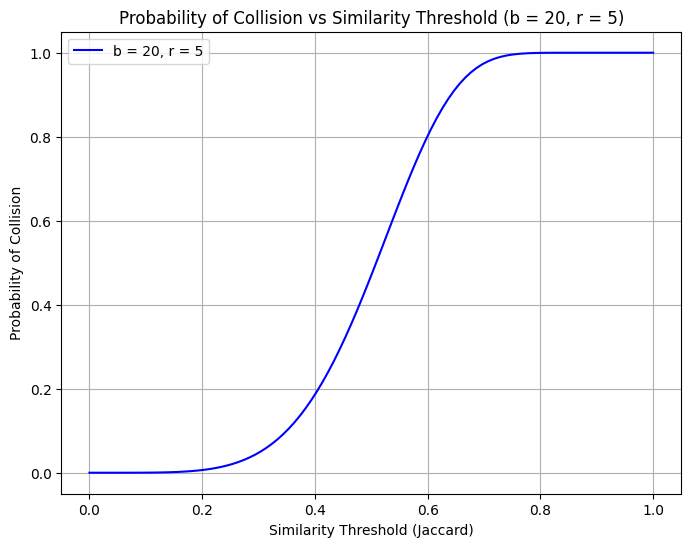

In [ ]:
s_values = np.linspace(0, 1, 100)
b = 20
r = 5

plotProbability(s_values, b, r)

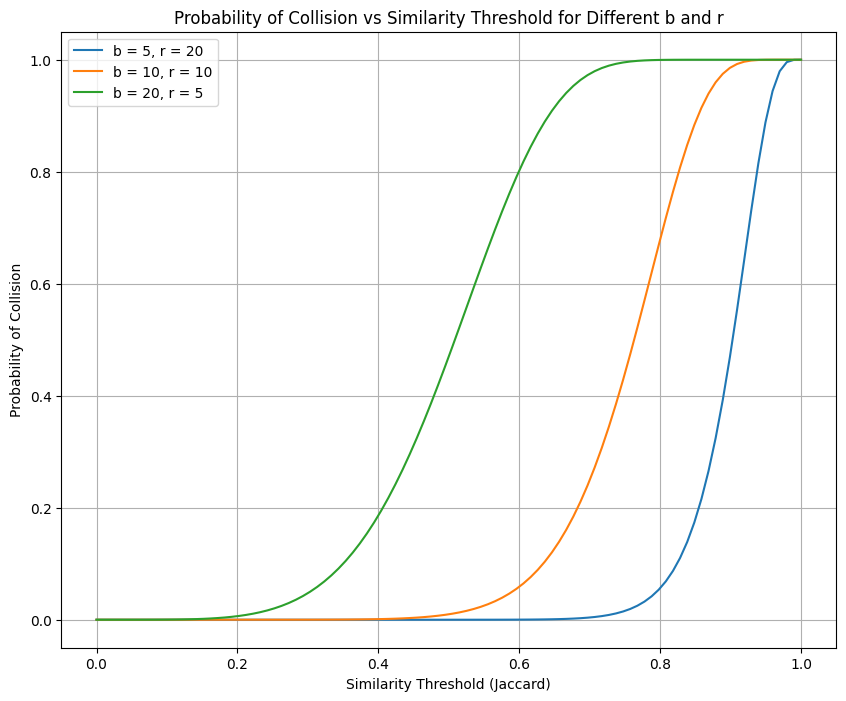

In [ ]:
def plotProbability(s, b, r):
    prob_collision = 1 - (1 - s**r)**b
    plt.plot(s, prob_collision, label=f"b = {b}, r = {r}")

s_values = np.linspace(0, 1, 100)
b_values = [5, 10, 20]
num_hash_functions = 100
r_values = [num_hash_functions // b for b in b_values]

plt.figure(figsize=(10, 8))

for b, r in zip(b_values, r_values):
    plotProbability(s_values, b, r)

plt.xlabel('Similarity Threshold (Jaccard)')
plt.ylabel('Probability of Collision')
plt.title('Probability of Collision vs Similarity Threshold for Different b and r')
plt.legend()

plt.grid(True)
plt.show()


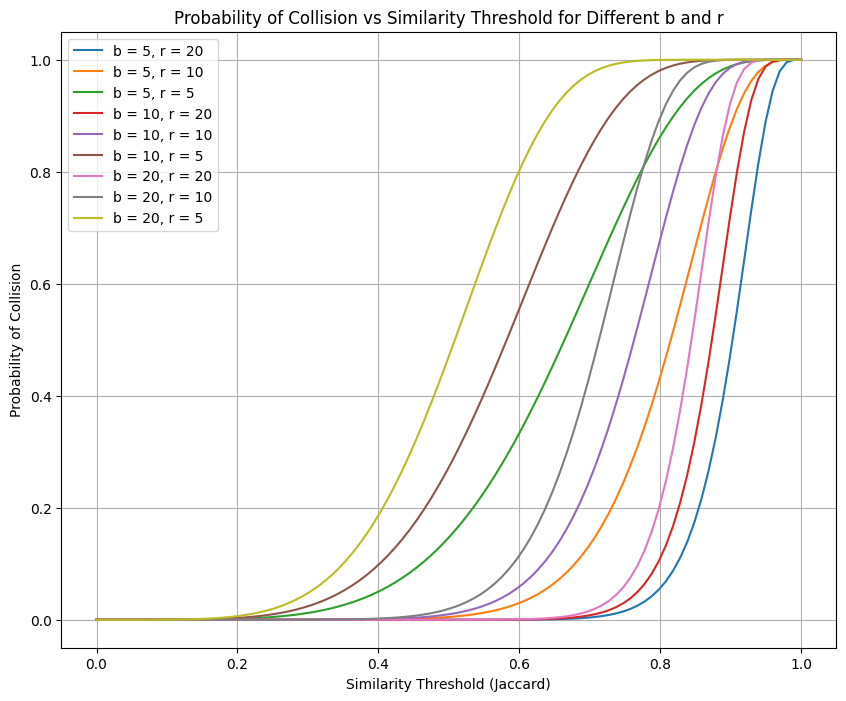

In [ ]:
def plotProbability(s, b, r):
    prob_collision = 1 - (1 - s**r)**b
    plt.plot(s, prob_collision, label=f"b = {b}, r = {r}")

s_values = np.linspace(0, 1, 100)

b_values = [5, 10, 20]
r_values = [20, 10, 5]

plt.figure(figsize=(10, 8))

for b in b_values:
    for r in r_values:
        plotProbability(s_values, b, r)

plt.xlabel('Similarity Threshold (Jaccard)')
plt.ylabel('Probability of Collision')
plt.title('Probability of Collision vs Similarity Threshold for Different b and r')
plt.legend()

plt.grid(True)
plt.show()

In [ ]:
def getJaccardSimilarityScore(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

This part implements Locality-Sensitive Hashing (LSH) to efficiently group similar documents based on their MinHash signatures. It divides the signature matrix into bands, where each band consists of a fixed number of rows (r). Each document's band-wise signature is hashed into a bucket, ensuring that similar documents are likely to end up in the same bucket. The lsh_buckets dictionary stores these document groupings. Then, the code iterates over the buckets, forming candidate pairs of documents that share at least one bucket. These pairs are stored in the nearest_neighbors dictionary, which helps identify potential similar documents before applying more expensive similarity calculations.

In [ ]:
nearest_neighbors = {}

for bucket_index, doc_ids in lsh_buckets.items():
    #print(f"Processing bucket {bucket_index} with {len(doc_ids)} documents")

    doc_ids_list = list(doc_ids)
    for i in range (len(doc_ids_list)):
        for j in range(i+1, len(doc_ids_list)):
                if doc_ids_list[i] not in nearest_neighbors:
                    nearest_neighbors[doc_ids_list[i]] = set()
                if doc_ids_list[j] not in nearest_neighbors:
                    nearest_neighbors[doc_ids_list[j]] = set()

                nearest_neighbors[doc_ids_list[i]].add(doc_ids_list[j])
                nearest_neighbors[doc_ids_list[j]].add(doc_ids_list[i])


In [ ]:
print(nearest_neighbors)

{0: set(), 20000: set(), 40000: set(), 10000: set(), 30000: set(), 1: set(), 24835: set(), 24457: set(), 9615: set(), 10001: set(), 34835: set(), 3095: set(), 34457: set(), 19615: set(), 20001: set(), 44835: set(), 13095: set(), 44457: set(), 29615: set(), 30001: set(), 23095: set(), 39615: set(), 40001: set(), 33095: set(), 43095: set(), 4835: {7859}, 4457: set(), 14835: set(), 14457: set(), 20002: set(), 2: set(), 10786: set(), 30786: set(), 40002: set(), 10002: set(), 786: set(), 20786: set(), 30002: set(), 40786: set(), 3: set(), 45834: set(), 10003: {5647, 41626}, 20003: set(), 30003: set(), 2489: set(), 5563: set(), 40003: set(), 12489: set(), 5834: {30438}, 15563: set(), 22489: set(), 15834: set(), 25563: set(), 32489: set(), 25834: set(), 35563: set(), 42489: set(), 35834: set(), 45563: set(), 28417: set(), 4: set(), 29192: {41402}, 38031: set(), 38417: {19500, 38724}, 10004: set(), 39192: set(), 48031: set(), 48417: {2030}, 20004: set(), 30004: set(), 40004: set(), 8031: set()

In [ ]:
# Remove the neighbors in same buckets but have similarity score < threshold s

n_copy = copy.deepcopy(nearest_neighbors)
s = 0.8

submission_id = []
submission_nid = []

for article_id, neighbor_ids in n_copy.items():
    for nid in list(neighbor_ids):
        score = getJaccardSimilarityScore(set(binary_matrix[article_id].indices),
                                          set(binary_matrix[nid].indices))
        if score < s:
            nearest_neighbors[article_id].remove(nid)
        else:
            submission_id.append(article_id)
            submission_nid.append(nid)

In [ ]:
data = pd.DataFrame()
data['article_id'] = submission_id
data['neighbor_id'] = submission_nid

data.sort_values(by=['article_id', 'neighbor_id'], inplace=True)

data.to_csv("submissions.csv", index=False)

print("Submission file saved as 'submissions.csv'")

Submission file saved as 'submissions.csv'


In [ ]:
from collections import Counter

neighbor_counts = Counter(data["article_id"])
print(neighbor_counts.most_common(10))

[(40696, 7), (5071, 6), (8565, 6), (8730, 6), (10104, 6), (12224, 6), (12485, 6), (15071, 6), (16969, 6), (17081, 6)]


In [ ]:
print("Unique article IDs after Jaccard filtering:", len(set(submission_id)))
print("First 10 submission_id values:", submission_id[:10])
print("First 10 nearest_neighbors keys:", list(nearest_neighbors.keys())[:10])

Unique article IDs after Jaccard filtering: 3007
First 10 submission_id values: [4835, 10003, 10003, 5834, 29192, 38417, 38417, 48417, 10005, 10571]
First 10 nearest_neighbors keys: [0, 20000, 40000, 10000, 30000, 1, 24835, 24457, 9615, 10001]


In [ ]:
data.head(100)

,article_id,neighbor_id
132,86,3289
134,86,18689
133,86,43239
139,90,34839
146,97,41669
...,...,...
1374,1013,29260
1373,1013,40449
1383,1024,4440
1408,1039,17158
